In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv('loan_data_2007_2014.csv')
df.head()

C:\Users\rizky\AppData\Local\Temp\ipykernel_12980\1521905525.py:1: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('loan_data_2007_2014.csv')


,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,1075358,1311748,3000,3000,3000.0,60 months,12.69,67.79,B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Feature Engineering

## loan_status - Target

In [5]:
df_train = df[(df['loan_status']=='Fully Paid') |
              (df['loan_status']=='Current') |
              (df['loan_status']=='Charged Off') |
              (df['loan_status']=='Default')].copy()

## mths_check - Months different from last payment and LC Check history

In [6]:
df_train['last_credit_pull_d'] = pd.to_datetime(df_train['last_credit_pull_d'], format='%b-%y')
df_train['last_pymnt_d'] = pd.to_datetime(df_train['last_pymnt_d'], format='%b-%y')
df_train['mths_check'] = round((df_train['last_credit_pull_d'] - df_train['last_pymnt_d'])/np.timedelta64(1, 'M'))

In [7]:
print(df_train[:1]['last_credit_pull_d'])
print(df_train[:1]['last_pymnt_d'])
print(df_train[:1]['mths_check'])

0   2016-01-01
Name: last_credit_pull_d, dtype: datetime64[ns]
0   2015-01-01
Name: last_pymnt_d, dtype: datetime64[ns]
0    12.0
Name: mths_check, dtype: float64


## finish_d - Date of payment is Fully Paid by issued_d and term

In [8]:
df_train['term'] = df_train['term'].str.replace(' months', '')
df_train['term'] = df_train['term'].astype('int')

In [9]:
df_train['issue_d'] = pd.to_datetime(df_train['issue_d'], format='%b-%y')
df_train['finish_d'] = ((df_train['issue_d'].dt.to_period('M')) + df_train['term']).dt.to_timestamp()

## mths_remain - months remaining for fully paid

In [10]:
df_train['mths_remain'] = round((df_train['finish_d'] - df_train['last_pymnt_d'])/np.timedelta64(1, 'M'))

In [11]:
print(df_train[:1]['finish_d'])
print(df_train[:1]['last_pymnt_d'])
print(df_train[:1]['mths_remain'])

0   2014-12-01
Name: finish_d, dtype: datetime64[ns]
0   2015-01-01
Name: last_pymnt_d, dtype: datetime64[ns]
0   -1.0
Name: mths_remain, dtype: float64


## paid_potention - Loaners potention to paid the months remaining based on income 

In [12]:
df_train['paid_potention'] = round(((df_train['annual_inc']/12) * df_train['mths_remain']) - df_train['out_prncp_inv'])

In [13]:
df_train['paid_potention']

0          -2000.0
1         110000.0
2           6126.0
3          -4100.0
4          72566.0
            ...   
466280    317426.0
466281    318500.0
466282    123572.0
466283    172917.0
466284     42026.0
Name: paid_potention, Length: 452272, dtype: float64

## emp_length

In [14]:
df_train = df_train.replace({'emp_length' : { '< 1 year' : '0 years', '1 year' : '1 years', '10+ years' : '10 years'}})
df_train['emp_length'] = df_train['emp_length'].fillna('0 years')
df_train['emp_length'] = df_train['emp_length'].replace(' years', '', regex=True)
df_train['emp_length'] = df_train['emp_length'].astype('int')
df_train['emp_length'].unique()

array([10,  0,  1,  3,  8,  9,  4,  5,  6,  2,  7])

## home_ownership

In [15]:
df_train = df_train.replace({'home_ownership' : { 'MORTGAGE' : 0, 'RENT' : 0, 'OWN' : 1, 'NONE': 1, 'ANY':1, 'OTHER':1}})

## other label

In [16]:
from sklearn.preprocessing import LabelEncoder

le=LabelEncoder()

df_train['grade'] = le.fit_transform(df_train['grade'])
df_train['verification_status']=le.fit_transform(df_train['verification_status'])
df_train['initial_list_status']=le.fit_transform(df_train['initial_list_status'])

# Preprocessing

In [17]:
df_train = df_train.fillna(0)

In [18]:
df_train1 = df_train[(df_train['loan_status']=='Fully Paid') |
              (df_train['loan_status']=='Charged Off') |
              (df_train['loan_status']=='Default')].copy()
df_train2 = df_train[(df_train['loan_status']=='Current')   |
              (df_train['loan_status']=='Charged Off')|
              (df_train['loan_status']=='Default')].copy()

In [19]:
df_train1 = df_train1.replace({'loan_status' : {'Fully Paid': 1, 'Charged Off': 0, 'Default': 0}})
df_train2 = df_train2.replace({'loan_status' : {'Current': 1, 'Charged Off': 0, 'Default': 0}})

In [20]:
X1 = df_train1[['loan_amnt','funded_amnt','int_rate', 'installment', 'grade', 'emp_length', 'home_ownership', 'annual_inc',
         'verification_status', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record',
         'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'initial_list_status', 'out_prncp_inv',
         'total_rec_late_fee', 'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'acc_now_delinq', 'tot_coll_amt',
         'total_rev_hi_lim', 'mths_check', 'mths_remain']].copy()
X2 = df_train2[['loan_amnt','funded_amnt','int_rate', 'installment', 'grade', 'emp_length', 'home_ownership', 'annual_inc',
         'verification_status', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record',
         'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'initial_list_status', 'out_prncp_inv',
         'total_rec_late_fee', 'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'acc_now_delinq', 'tot_coll_amt',
         'total_rev_hi_lim', 'mths_check', 'mths_remain']].copy()
Y1 = df_train1['loan_status'].copy()
Y2 = df_train2['loan_status'].copy()
X1.head()

,loan_amnt,funded_amnt,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,dti,...,initial_list_status,out_prncp_inv,total_rec_late_fee,collections_12_mths_ex_med,mths_since_last_major_derog,acc_now_delinq,tot_coll_amt,total_rev_hi_lim,mths_check,mths_remain
0,5000,5000,10.65,162.87,1,10,0,24000.0,2,27.65,...,0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,12.0,-1.0
1,2500,2500,15.27,59.83,2,0,0,30000.0,1,1.00,...,0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,5.0,44.0
2,2400,2400,15.96,84.33,2,10,0,12252.0,0,8.72,...,0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,19.0,6.0
3,10000,10000,13.49,339.31,2,10,0,49200.0,1,20.00,...,0,0.0,16.97,0.0,0.0,0.0,0.0,0.0,0.0,-1.0
5,5000,5000,7.90,156.46,0,3,0,36000.0,1,11.20,...,0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,8.0,-1.0


In [21]:
from sklearn.model_selection import train_test_split

X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, Y1, test_size=0.25,
                                                    random_state=42)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, Y2, test_size=0.25,
                                                    random_state=42)
print(len(X_train1))
print(len(X_test1))

171034
57012


In [22]:
from imblearn.over_sampling import SMOTE

oversample = SMOTE()
X_smote1, y_smote1 = oversample.fit_resample(X_train1, y_train1)
X_smote2, y_smote2 = oversample.fit_resample(X_train2, y_train2)

In [23]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_smote1[:])

X_smote1[:] = scaler.transform(X_smote1[:])
X_test1[:] = scaler.transform(X_test1[:])
X_train1[:] = scaler.transform(X_train1[:])

X_smote2[:] = scaler.transform(X_smote2[:])
X_test2[:] = scaler.transform(X_test2[:])
X_train2[:] = scaler.transform(X_train2[:])

# Feature Importance

In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

feature_names = [f"feature {i}" for i in range(X1.shape[1])]

forest1 = RandomForestClassifier(random_state=0)
forest1.fit(X_smote1, y_smote1)

RandomForestClassifier(random_state=0)

In [25]:
yy = forest1.predict(X_test1)
print(classification_report(y_test1, yy))

              precision    recall  f1-score   support

           0       0.67      0.60      0.63     10900
           1       0.91      0.93      0.92     46112

    accuracy                           0.87     57012
   macro avg       0.79      0.76      0.78     57012
weighted avg       0.86      0.87      0.86     57012



In [26]:
forest2 = RandomForestClassifier(random_state=0)
forest2.fit(X_smote2, y_smote2)

RandomForestClassifier(random_state=0)

In [27]:
yy = forest1.predict(X_test2)
print(classification_report(y_test2, yy))

              precision    recall  f1-score   support

           0       0.23      0.90      0.37     10598
           1       0.96      0.43      0.59     56286

    accuracy                           0.51     66884
   macro avg       0.59      0.67      0.48     66884
weighted avg       0.84      0.51      0.56     66884



Text(0.5, 0, 'Feature Importance')

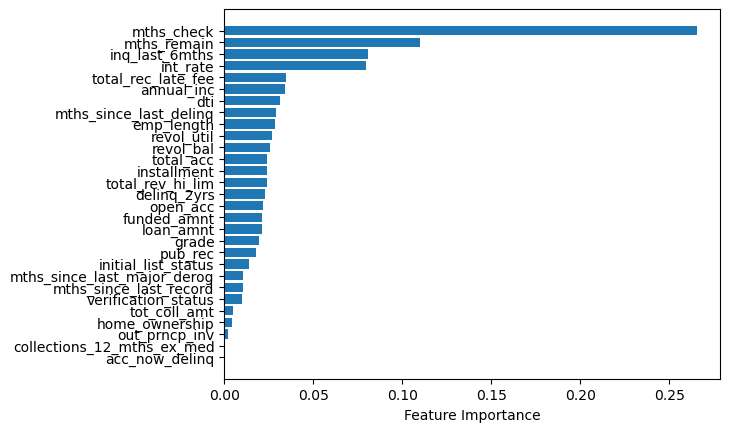

In [28]:
sort = forest1.feature_importances_.argsort()
plt.barh(X_smote1.columns[sort], forest1.feature_importances_[sort])
plt.xlabel("Feature Importance")

Text(0.5, 0, 'Feature Importance')

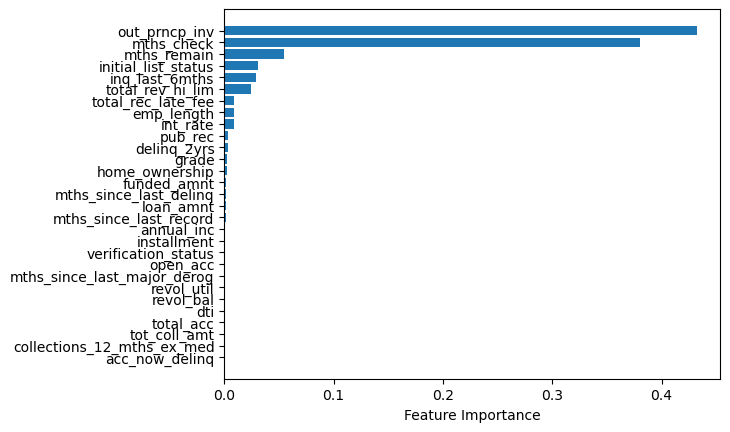

In [29]:
sort = forest2.feature_importances_.argsort()
plt.barh(X_smote2.columns[sort], forest2.feature_importances_[sort])
plt.xlabel("Feature Importance")

In [30]:
df_train2['out_prncp_inv'].corr(df_train2['loan_status'])

0.4616437517520273

In [45]:
len(df_train[(df_train['loan_status']=='Default') &
         (df_train['mths_remain']>=0)])

831

In [46]:
len(df_train[(df_train['loan_status']=='Default') &
         (df_train['mths_remain']<=0)])

1